In [76]:
import os
import sys

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from scipy import stats
import yfinance as yf
import autopep8
import seaborn as sns


# set seaborn style

sns.set_style("whitegrid")

# create our portfolio of equities
tickers = ['LYG', 'BP', 'RYCEY']

# cet the investment weights
weights = np.array([.333, .333,  .333])

# set an initial investment level
initial_investment = 100000

# download closing prices
data = pdr.get_data_yahoo(tickers, start="2018-01-01",
                          end=datetime.date.today())['Adj Close']

# from the closing prices, calculate daily returns

# simple Return
data = data.pct_change().dropna()

# log return
#returns = np.log(data/data.shift(1)).dropna()

data.head(5)

Symbols,LYG,BP,RYCEY
Date,,,
2018-01-03,-0.013228,0.011562,0.006114
2018-01-04,0.010724,0.003965,0.012153
2018-01-05,0.002653,0.001394,0.001715
2018-01-08,0.000000,-0.000464,0.010274
2018-01-09,0.002645,-0.004875,-0.007627


In [31]:
# PROCESS

# generate var-cov matrix

cov_matrix = data.cov()

# calculate mean returns for each stock
avg_return = data.mean()

# calculate mean returns for portfolio overall,
# using dot product to normalize individual means against investment weights

port_mean = avg_return.dot(weights)

# calculate portfolio standard deviation

port_std = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# calculate investment daily average value

mean_investment = initial_investment * (1 + port_mean)

# calculate investment daily standard deviation

investment_std = mean_investment * port_std

In [32]:
# print results

print(f'daily mean investment value: {mean_investment}')
print(f'daily investment standard deviation: {investment_std}')

daily mean investment value: 99964.63348676622
daily investment standard deviation: 2366.3913043196662


In [33]:
# find daily VAR

# set critical level
critical_level = 0.05

# find critical investment value
cutoff1 = stats.norm.ppf(critical_level, mean_investment, investment_std)

# find daily VAR

var_1d = np.round(initial_investment - cutoff1, 2)

print(f'daily VAR at {critical_level * 100}% is {var_1d}')

daily VAR at 5.0% is 3927.73


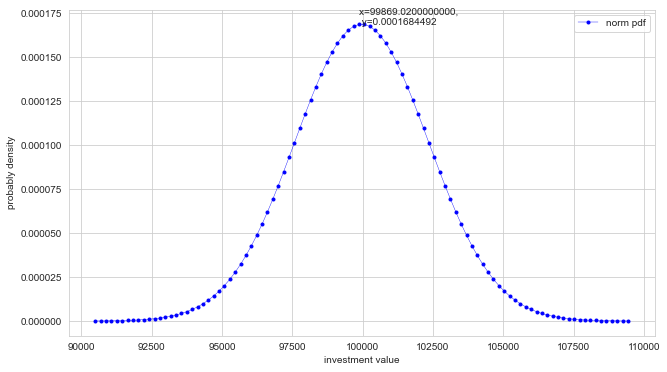

In [44]:
# plot portfolio density function

fig, ax = plt.subplots()

x = np.linspace(mean_investment - 4 * investment_std,
                mean_investment + 4 * investment_std, 100)

y = norm.pdf(x, mean_investment, investment_std,)

ax.plot(x, y, color='b', marker='.', linestyle='-',
        linewidth=0.4, label='norm pdf')

ax.set_xlabel('investment value')
ax.set_ylabel('probably density')

ymax = max(y)
xmax = np.round(x[np.argmax(y)], 2)
text = "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))
fig.set_size_inches(10.5, 6)
ax.legend()

1 day VaR @ 95% confidence: 3927.73
2 day VaR @ 95% confidence: 5554.65
3 day VaR @ 95% confidence: 6803.03
4 day VaR @ 95% confidence: 7855.46
5 day VaR @ 95% confidence: 8782.67
6 day VaR @ 95% confidence: 9620.93
7 day VaR @ 95% confidence: 10391.8
8 day VaR @ 95% confidence: 11109.3
9 day VaR @ 95% confidence: 11783.19
10 day VaR @ 95% confidence: 12420.57
11 day VaR @ 95% confidence: 13026.81
12 day VaR @ 95% confidence: 13606.06
13 day VaR @ 95% confidence: 14161.63
14 day VaR @ 95% confidence: 14696.22
15 day VaR @ 95% confidence: 15212.03


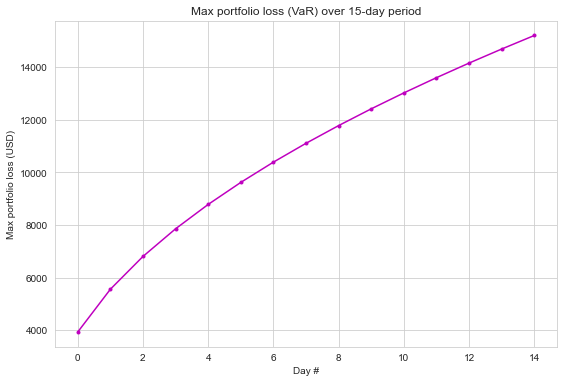

In [54]:
# calculate n Day VaR
var_array = []
num_days = 15
for x in range(1, num_days+1):
    var_array.append(np.round(var_1d * np.sqrt(x), 2))
    print(str(x) + " day VaR @ 95% confidence: " +
          str(np.round(var_1d * np.sqrt(x), 2)))

# build plot

fig, ax = plt.subplots()

ax.set_xlabel("Day #")
ax.set_ylabel("Max portfolio loss (USD)")
ax.set_title("Max portfolio loss (VaR) over 15-day period")
ax.plot(var_array, "m", marker='.')
fig.set_size_inches(9, 6)

NormaltestResult(statistic=132.44194780556313, pvalue=1.7401891149020115e-29)

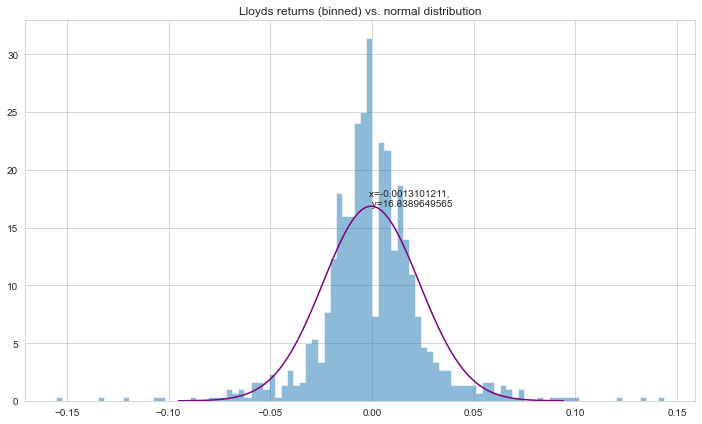

In [73]:
# plot the dailt return a one equity

fig, ax = plt.subplots()

data['LYG'].hist(bins=100, histtype="stepfilled", alpha=0.5, density=True)

x = np.linspace(port_mean - 4*port_std, port_mean + 4*port_std, 100)

plt.plot(x, norm.pdf(x, port_mean, port_std), color='purple', linestyle='-')
plt.title("Lloyds returns (binned) vs. normal distribution")

ymax = max(norm.pdf(x, port_mean, port_std))
xmax = x[np.argmax(y)]
text = "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))

fig.set_size_inches(12, 7)


# test if equity follows a normal distribution
st.normaltest(data['LYG'], nan_policy='omit')

NormaltestResult(statistic=191.221487695948, pvalue=2.99765422491188e-42)

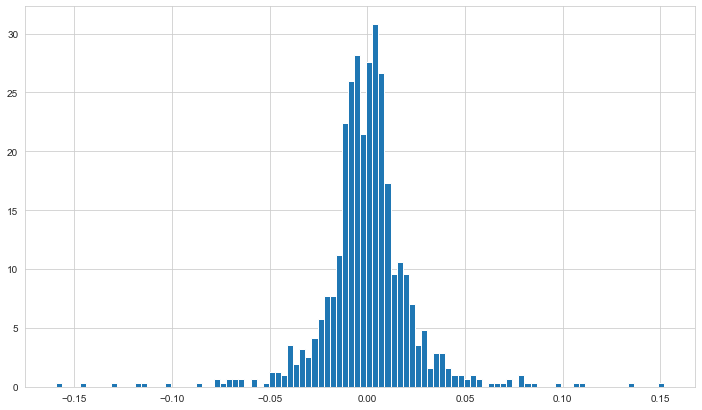

In [75]:
# plot the actual daily returns as histograms

port = data.dot(weights)

fig, ax = plt.subplots()

port.hist(bins=100, density=True)

fig.set_size_inches(12, 7)


# test if the daily returns follows a normail distribution

st.normaltest(port, axis=0, nan_policy='omit')